# test lseg's ability to detect wall/room
- form vlmap, index with 'room'/'bedroom'/'livingroom'/'kitchen'/'bathroom'/'corridor'/'balcony'/'other'
- directly index image, then

In [1]:
import matplotlib.pyplot as plt
def draw_hist(pc):
    # 绘制直方图
    plt.hist(pc, bins=30, alpha=0.75, color='blue', edgecolor='black')

    # 添加标题和标签
    plt.title('Data Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # 显示图像
    plt.show()

In [ ]:

map_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/vlmap_cam/vlmaps_cam.h5df'
import matplotlib.pyplot as plt

import numpy as np
mask = np.load('scored_list.npy')


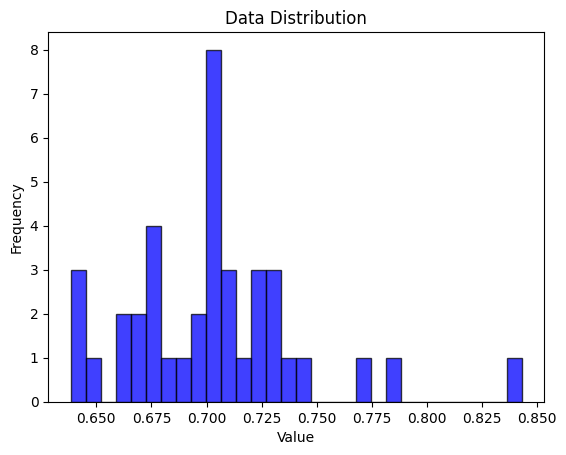

In [3]:
# 计算每一行的最大值
vector_eg = mask[0]
draw_hist(vector_eg)


In [2]:
from pathlib import Path
import hydra
from omegaconf import DictConfig
import sys, os
print(sys.path)
from vlmaps.vlmaps.map.vlmap import VLMap
from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
from vlmaps.vlmaps.utils.visualize_utils import (
    pool_3d_label_to_2d,
    pool_3d_rgb_to_2d,
    visualize_rgb_map_3d,
    visualize_masked_map_2d,
    visualize_heatmap_2d,
    visualize_heatmap_3d,
    visualize_masked_map_3d,
    get_heatmap_from_mask_2d,
    get_heatmap_from_mask_3d,
)

import types
import numpy as np

# 原始字典
map_config = {
    'map_type': 'IsaacSimMap',
    'pose_info': {
        'pose_type': 'camera_base',
        'rot_type': 'quat',
        'camera_height': 1.5,
        'base2cam_rot': [1, 0, 0, 0, -1, 0, 0, 0, -1],
        'base_forward_axis': [0, 0, -1],
        'base_left_axis': [-1, 0, 0],
        'base_up_axis': [0, 1, 0]
    },
    'skip_frame': 1,
    'cam_calib_mat': [221, 0, 128, 0, 221, 128, 0, 0, 1],
    'grid_size': '${params.gs}',
    'cell_size': '${params.cs}',
    'robot_z': '${params.robot_z}',
    'depth_sample_rate': 50,
    'dilate_iter': 3,
    'gaussian_sigma': 1.0,
    'customize_obstacle_map': False,
    'potential_obstacle_names': ['wall', 'floor', 'chair', 'door', 'table', 'picture', 'cabinet', 'cushion', 'window', 'sofa', 'bed', 'curtain', 'chest_of_drawers', 'plant', 'sink', 'stairs', 'ceiling', 'toilet', 'stool', 'towel', 'mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects'],
    'obstacle_names': ['wall', 'floor', 'chair', 'door', 'table', 'picture', 'cabinet', 'cushion', 'window', 'sofa', 'bed', 'curtain', 'chest_of_drawers', 'plant', 'sink', 'stairs', 'ceiling', 'toilet', 'stool', 'towel', 'mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects'],
    'categories': 'mp3d'
}

# 将字典转换为 SimpleNamespace 对象
map_config_ns = types.SimpleNamespace(**map_config)
map_config_ns.pose_info = types.SimpleNamespace(**map_config_ns.pose_info)

# 示例使用
self = types.SimpleNamespace()
self.map_config = map_config_ns
self.base2cam_tf = np.zeros((3, 3))  # 假设 self.base2cam_tf 是一个 3x3 的矩阵

# 访问并设置属性
self.base2cam_tf[:3, :3] = np.array(self.map_config.pose_info.base2cam_rot).reshape((3, 3))

vlmap_save_path =  '/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/'
# vlmap_save_path ='/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7/id_5/'
vlmap = VLMap(self.map_config, data_dir= vlmap_save_path)
vlmap.load_map(vlmap_save_path)


['/home/xiaxinyuan/.conda/envs/isaacsim/lib/python310.zip', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/lib-dynload', '', '/home/xiaxinyuan/.local/lib/python3.10/site-packages', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages', '__editable__.omni_isaac_lab-0.22.1.finder.__path_hook__', '__editable__.omni_isaac_lab_assets-0.1.3.finder.__path_hook__', '__editable__.omni_isaac_lab_tasks-0.10.0.finder.__path_hook__', '/ssd/xiaxinyuan/code/w61-grutopia', '/home/xiaxinyuan/Hierarchical-Localization', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/setuptools/_vendor']
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1
/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/vlmap_cam/vlmaps_cam.h5df


True

In [5]:
import cv2
import matplotlib.pyplot as plt
def display_image_in_notebook(image_path):
    # 读取图像
    image = cv2.imread(image_path)
    
    # 检查图像是否成功读取
    if image is None:
        print(f"Failed to load image from {image_path}")
        return
    
    # 将图像从 BGR 转换为 RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 在 Jupyter Notebook 中显示图像
    plt.imshow(image_rgb)
    plt.axis('off')  # 关闭坐标轴
    plt.show()


vlmap._init_clip()
cat = 'bed'
gs =200
cs = 0.1
decay_rate = 0.02


clip model is already initialized


In [6]:
def visualize_2d(cat,mask):
    # init categories with cat and other:
    mask = vlmap.index_map(cat, with_init_cat=False,threshold=0)
    mask_2d = pool_3d_label_to_2d(mask, vlmap.grid_pos, gs)
    rgb_2d = pool_3d_rgb_to_2d(vlmap.grid_rgb, vlmap.grid_pos, gs)

    print(vlmap.map_save_path)

    save_path = Path(vlmap_save_path) /'vlmap_cam'/ f"{cat}_masked_2d_binary.jpg"
    visualize_masked_map_2d(rgb_2d, mask_2d, save_path = save_path)
    display_image_in_notebook(save_path)

    heatmap = get_heatmap_from_mask_2d(mask_2d, cell_size=cs, decay_rate=decay_rate)
    save_path = Path(vlmap_save_path)/'vlmap_cam'/ f"{cat}_heatmap_2d_binary.jpg"
    visualize_heatmap_2d(rgb_2d, heatmap,save_path=save_path)
    display_image_in_notebook(save_path)

def visualize_3d(cat, mask):
    save_path = f'{vlmap_save_path}/vlmap_cam/{cat}_masked_3d_binary.pcd'
    visualize_masked_map_3d(vlmap.grid_pos, mask, vlmap.grid_rgb, save_path = save_path)
    heatmap = get_heatmap_from_mask_3d(
            vlmap.grid_pos, mask, cell_size=cs, decay_rate=decay_rate
        )
    save_path = f'{vlmap_save_path}/vlmap_cam/{cat}_heatmap_3d_binary.pcd'
    visualize_heatmap_3d(vlmap.grid_pos, heatmap, vlmap.grid_rgb, save_path = save_path)


In [32]:
save_path

'/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7/id_5//vlmap_cam/bed_heatmap_3d_binary.pcd'

In [28]:
vlmap.grid_pos.shape

(4999, 3)

In [ ]:
vlmap.scores_mat
draw_hist(vlmap.scores_mat[1])


In [10]:
np.sum(mask)

88

Image saved to /ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/vlmap_cam/door_masked_2d.jpg


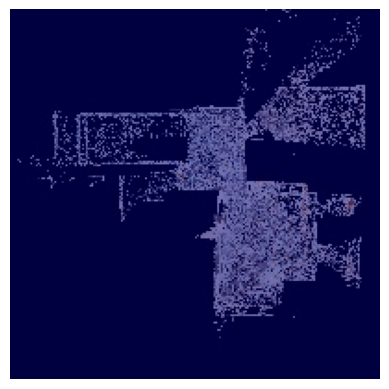

Image saved to /ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/vlmap_cam/door_heatmap_2d.jpg


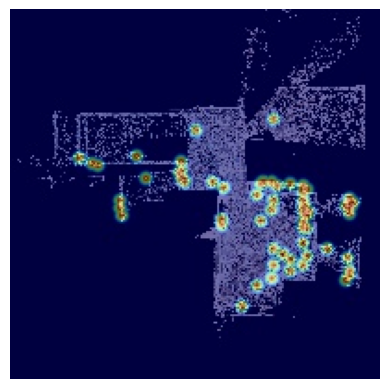

In [26]:

vlmap.init_categories(mp3dcat[1:-1])
mask = vlmap.index_map(cat, with_init_cat=True,threshold = 0.86)

mask_2d = pool_3d_label_to_2d(mask, vlmap.grid_pos, gs)
rgb_2d = pool_3d_rgb_to_2d(vlmap.grid_rgb, vlmap.grid_pos, gs)
save_path = Path(vlmap_save_path) /'vlmap_cam'/ f"{cat}_masked_2d.jpg"
visualize_masked_map_2d(rgb_2d, mask_2d,save_path=save_path)
display_image_in_notebook(save_path)


heatmap = get_heatmap_from_mask_2d(mask_2d, cell_size=cs, decay_rate=decay_rate)
save_path = Path(vlmap_save_path) /'vlmap_cam'/ f"{cat}_heatmap_2d.jpg"
visualize_heatmap_2d(rgb_2d, heatmap,save_path=save_path)
display_image_in_notebook(save_path)

In [42]:

max_idx = np.argmax(vlmap.scores_mat, axis=1)
topdown_mask = np.zeros([200,200]).astype(int)
for pos,lbl in zip(vlmap.grid_pos,max_idx):
   topdown_mask[pos[0],pos[1]] = int(lbl+1)



from vlmaps.vlmaps.utils.mapping_utils import get_new_mask_pallete,get_new_pallete
# labels: ['null', other labels in mp3d]

labels = mp3dcat


In [44]:

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(topdown_mask, new_palette, out_label_flag=True, labels=labels)
seg = mask.convert("RGBA")

# 创建图像和分割结果的子图
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(seg)
ax.set_title("Segmentation Result")
ax.axis("off")

# 创建图例
legend_fig, legend_ax = plt.subplots(figsize=(15, 2))
legend_ax.legend(handles=patches, loc="center", ncol=10, prop={"size": 10})
legend_ax.axis("off")

# 保存图像和图例
plt.tight_layout()
fig.savefig('segmentation_result.jpg', bbox_inches='tight')
legend_fig.savefig('segmentation_legend.jpg', bbox_inches='tight')

# 关闭图形以释放内存
plt.close(fig)
plt.close(legend_fig)

<BarContainer object of 10 artists>

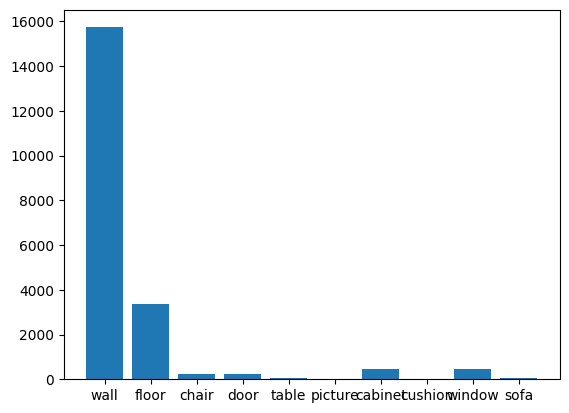

In [15]:

max_values = np.max(mask, axis=1)

# 计算每一行最大值对应的索引
max_indices = np.argmax(mask, axis=1)

# draw_hist(max_values)

from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
indexed_dict = mp3dcat[1:]

sum_of_idx = np.zeros(len(indexed_dict))
for i in max_indices:
    sum_of_idx[i] += 1

plt.bar(indexed_dict[:10], sum_of_idx[:10])


<BarContainer object of 10 artists>

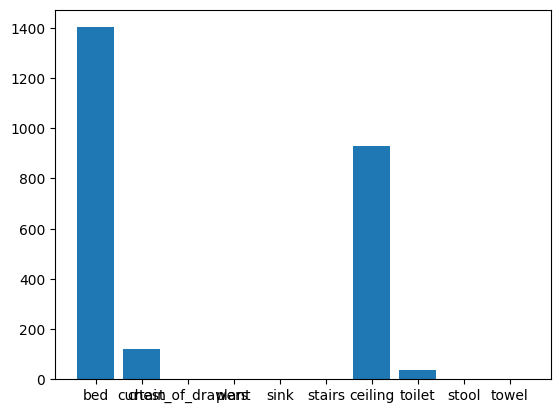

In [16]:


plt.bar(indexed_dict[10:20], sum_of_idx[10:20])


['mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects']


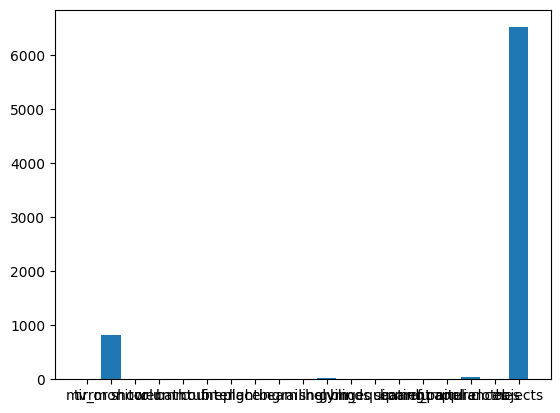

In [18]:


plt.bar(indexed_dict[20:], sum_of_idx[20:])
print(indexed_dict[20:])


In [10]:
from vlmaps.vlmaps.utils.llm_utils import parse_spatial_instruction

import os
import json
def read_instructions_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    print(f"Instructions read from {file_path}")
    return data

# 使用示例
file_path = 'tmp/instructions.json'
instructions = read_instructions_from_file(file_path)

parse_spatial_instruction(instructions[0]['instruction'])
# # 通过索引访问数据
# for instruction in instructions:
#     print(f"Idx: {instruction['idx']}, Instruction: {instruction['instruction']}")


Instructions read from tmp/instructions.json


"**Step-by-Step Instructions:**\n\n1. **Identify the Center Unit:**\n   - Locate the center unit in your environment.\n\n2. **Approach the Right Side of the Center Unit:**\n   - Navigate to the position to the right side of the center unit.\n\n3. **Move Around the Right Side:**\n   - Move around the right side of the center unit, ensuring you're circumventing it without collision.\n\n4. **Locate the Dining Table and Mirror Room:**\n   - Identify the right side doorway leading to the room with the dining table and a mirror.\n\n5. **Stop by the Right Side Doorway:**\n   - Position yourself by the right side doorway to complete the task.\n\n**Execution Commands:**\n\n1. **Identify and Navigate to the Center Unit:**\n\n```python\nrobot.move_to_object('center_unit')\nrobot.move_right('center_unit')\n```\n\n2. **Move Around the Center Unit:**\n\n```python\nrobot.move_around_right('center_unit')\n```\n\n3. **Locate the Dining Table and Mirror Room:**\n\n```python\nrobot.move_to_doorway('dinin

In [4]:
from vlmaps.vlmaps.utils.index_utils import find_similar_category_id
from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
find_similar_category_id('kitchen', mp3dcat)


void,wall,floor,chair,door,table,picture,cabinet,cushion,window,sofa,bed,curtain,chest_of_drawers,plant,sink,stairs,ceiling,toilet,stool,towel,mirror,tv_monitor,shower,column,bathtub,counter,fireplace,lighting,beam,railing,shelving,blinds,gym_equipment,seating,board_panel,furniture,appliances,clothes,objects
cabinet


7

In [ ]:
import gzip
import json
import copy
import os
starrt_pos_dict = {}
instruction_list = []
def load_data(split):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    total_scans = []
    load_data = []
    with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
        data = json.load(f)
        for item in data["episodes"]:
            
            name = os.path.splitext(os.path.basename(item['scene_id']))[0]
            start_position = item['instruction']['instruction_text']
            print(name,item['episode_id'], item['trajectory_id'],start_position)
            instruction_list.append({'idx':name,'instruction':start_position})
            # item["original_start_position"] = copy.copy(item["start_position"])
            # item["original_start_rotation"] = copy.copy(item["start_rotation"])
            # item["start_position"] = [item["original_start_position"][0], -item["original_start_position"][2], item["original_start_position"][1]]
            # item["start_rotation"] = [-item["original_start_rotation"][3], item["original_start_rotation"][0], item["original_start_rotation"][2], -item["original_start_rotation"][1]] # [x,y,z,-w] => [w,x,y,z]
            # item["scan"] = item["scene_id"].split("/")[1]
            # item["c_reference_path"] = []
            # if "reference_path" in item.keys():
            #     for path in item["reference_path"]:
            #         item["c_reference_path"].append([path[0], -path[2], path[1]])
            #     item["reference_path"] = item["c_reference_path"]
            #     del item["c_reference_path"]
            # load_data.append(item)
            # total_scans.append(item["scan"])

    # return load_data, list(set(total_scans))

# splits = ['train', 'val_seen', 'val_unseen', 'test']
splits = ['train']
for split in splits:
    load_data(split)

# def save_dict_to_file(data, file_path):
#     with open(file_path, 'w', encoding='utf-8') as file:
#         json.dump(data, file, ensure_ascii=False, indent=4)
#     print(f"Dictionary saved to {file_path}")
# file_path = 'tmp/instructions.json'
# save_dict_to_file(instruction_list, file_path)


In [3]:
import json
json_file = '/ssd/share/vlmap/vlmaps_dataset/5LpN3gDmAk7_1/spatial_goal_navigation_tasks.json'
with open(json_file, 'r', encoding='utf-8') as file:
    data = json.load(file)
    print(f"Instructions read from {json_file}")


Instructions read from /ssd/share/vlmap/vlmaps_dataset/5LpN3gDmAk7_1/spatial_goal_navigation_tasks.json


In [16]:
data[0]['instruction']


'move first to the left side of the counter in front of you, face the counter and then move to the west of the counter, later, with the counter on your right, go to the east of the chair in front of you, and finally move to the sofa in front of you.'

In [4]:
from vlmaps.vlmaps.utils.llm_utils import parse_spatial_instruction
parse_spatial_instruction(data[0]['instruction'])


"```python\nself.move_to_left('counter')\nself.face('counter')\nself.move_west('counter')\nself.with_object_on_right('counter')\nself.move_east('chair')\nself.move_to_object('sofa')\n```"

In [7]:
test_str = 'for i in range(10):\n print(i)'
exec(test_str)


0
1
2
3
4
5
6
7
8
9


In [8]:
import re

def extract_self_methods(input_string):
    """
    从输入字符串中提取以 `self.` 开头的所有部分，并放到一个列表中
    :param input_string: 输入字符串
    :return: 提取的部分列表
    """
    # 使用正则表达式匹配以 `self.` 开头的部分
    matches = re.findall(r'self\.\w+\(.*?\)', input_string)
    return matches

# 示例输入
input_string = "python\nself.move_to_left('counter')\nself.face('counter')\nself.move_west('counter')\nself.with_object_on_right('counter')\nself.move_east('chair')\nself.move_to_object('sofa')\n"

# 提取以 `self.` 开头的部分
extracted_methods = extract_self_methods(input_string)

# 打印结果
print(extracted_methods)


["self.move_to_left('counter')", "self.face('counter')", "self.move_west('counter')", "self.with_object_on_right('counter')", "self.move_east('chair')", "self.move_to_object('sofa')"]


In [ ]:
pcd_global = o3d.geometry.PointCloud()
pcd_global.points = o3d.utility.Vector3dVector(pc_filtered)
visualize_pc(pcd_global, headless = True)


In [ ]:
# get camera:
self.env._runner.current_tasks[self.task_name].robots[self.robot_name].sensors['pano_camera_0'].get_world_pose()
rgb = self.topdown_camera.get_data()["rgba"] # topdown_camera: grutopia_camera
cv2.imwrite('panp_rgb.jpg',rgb)

# get curr pos
self.issac_camera.get_world_pose()